### Optimal parameters

<font color='red'>**Warning!**</font> The execution of the following cell takes considerable resources and time.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read csv file into a pandas dataframe
max_n_clusters = pd.read_csv('../data/max_n_clusters.csv')
max_n_clusters = max_n_clusters.set_index('min_points')

In [4]:
# Read tweets
data_dir = os.path.realpath("../data")
tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Project tweets to Lambert 93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [5]:
# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['ts'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
# Convert ts in tweets to cumulative seconds
tweets['ts'] -= tweets['ts'].min()

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['ts'].values.reshape(-1, 1), scaled))

# Get coordinates
COORDS = tweets.loc[:, ['x_m','y_m']].values

# Calculate all pairwise normalized distances
dist_norm = np.linalg.norm(data[:, np.newaxis, 1:] - data[np.newaxis, :, 1:], axis=-1)
dist_norm.sort(axis=1)

# Calculate all pairwise terrain distances
dist = np.linalg.norm(COORDS[:, np.newaxis, :] - COORDS[np.newaxis, :, :], axis=-1)
dist.sort(axis=1)

In [6]:
# Create a min_dist list ranging from 0.05 to 0.15
min_dist = np.array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15])
eps1_terrain = (min_dist * dist[-1][-1]) / dist_norm[-1][-1]
eps1_terrain = eps1_terrain / 1000
eps1_terrain = eps1_terrain.astype(int)

# Create a min_points list
min_points = [i for i in range(16, 24)]

In [5]:
# Calculate max number of clusters for each min_dist and min_points combination
max_n_clusters = np.zeros((len(min_points), len(min_dist)))

for i in range(len(min_dist) ):
    md = min_dist[i]
    for j in range(len(min_points)):
        mp = min_points[j]
        # Create ST-DBSCAN object
        st_dbscan = ST_DBSCAN(eps1=md, eps2=60*10, min_samples=mp, metric='euclidean', n_jobs=-1).fit(data)
        # Get number of clusters
        n_clusters = st_dbscan.labels.max() + 2
        # Store number of clusters
        max_n_clusters[j, i] = n_clusters

# Add min_dist and min_points to max_n_clusters
max_n_clusters = np.hstack((np.array(min_points).reshape(-1, 1), max_n_clusters))
max_n_clusters = np.vstack((np.array([0] + min_dist).reshape(1, -1), max_n_clusters))

# Create a dataframe from max_n_clusters
max_n_clusters = pd.DataFrame(max_n_clusters, columns=['min_points'] + [f'max_dist={i}' for i in min_dist])

# Set min_points as index
max_n_clusters.set_index('min_points', inplace=True)

# Remove first row
max_n_clusters = max_n_clusters.iloc[1:, :]

In [6]:
# Save to csv
max_n_clusters.to_csv(os.path.join(data_dir, "max_n_clusters.csv"))
max_n_clusters

,max_dist=0.05,max_dist=0.06,max_dist=0.07,max_dist=0.08,max_dist=0.09,max_dist=0.1,max_dist=0.11,max_dist=0.12,max_dist=0.13,max_dist=0.14,max_dist=0.15
min_points,,,,,,,,,,,
16.0,11.0,8.0,8.0,8.0,6.0,6.0,6.0,7.0,7.0,7.0,6.0
17.0,10.0,7.0,7.0,7.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0
18.0,10.0,7.0,7.0,7.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0
19.0,9.0,8.0,7.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
20.0,9.0,7.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0
21.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
22.0,8.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
23.0,12.0,9.0,8.0,8.0,8.0,8.0,8.0,6.0,6.0,6.0,6.0


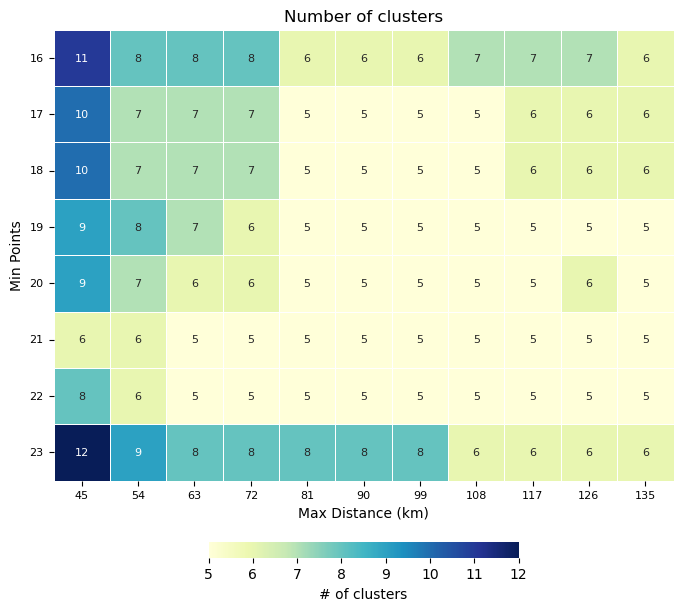

In [13]:
# Plot max_n_clusters
fig, ax_cluster = plt.subplots()
# Set figure size
fig.set_size_inches(8, 8)

# annot parameter is used to show the values in the heatmap cells
ax_cluster = sns.heatmap(
    max_n_clusters,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    ax=ax_cluster,
    linewidths=0.6,
    linecolor="white",
    cbar=True,
    cbar_kws={"shrink": 0.5, "label": "# of clusters", "orientation": "horizontal", "pad": 0.1},
    annot_kws={"size": 8},
    square=True,
    xticklabels=True,
    yticklabels=True,

)
ax_cluster.set_title("Number of clusters")
ax_cluster.set_xlabel("Max Distance (km)")
ax_cluster.set_ylabel("Min Points")

# Set xlabel values
ax_cluster.set_xticklabels([f"{i:.0f}" for i in eps1_terrain], rotation=0, fontsize=8)
ax_cluster.set_yticklabels([f"{i:.0f}" for i in min_points], rotation=0, fontsize=8)

plt.show()

In [9]:
ax_cluster.get_figure().savefig('./images/st_dbscan/st_dbscan_param.png', dpi=300, bbox_inches='tight', facecolor=ax_cluster.get_figure().get_facecolor(), edgecolor='none')